<a href="https://www.kaggle.com/code/alaomuideenabiola/tumor-classification?scriptVersionId=233838780" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tumor-datasets002/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/tumor-datasets002/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/tumor-datasets002/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/tumor-datasets002/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/tumor-datasets002/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/tumor-datasets002/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/tumor-datasets002/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/tumor-datasets002/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/tumor-datasets002/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/tumor-datasets002/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/tumor-datasets002/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/tumor-datasets002/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/tumor-datasets002/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/tumor-datasets002/Training/pituitary/Tr-pi_0789.jpg
/kaggle/input/tumor-datasets002/Training/pituitary/Tr-pi_1445.jpg
/kaggle/in

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from collections import Counter
from torchvision import datasets, transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import os



In [3]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cuda


In [4]:
# Define the dataset path
data_dir = '/kaggle/input/tumor-traindataset/Training'

# Load the dataset without transformations
dataset = datasets.ImageFolder(root=data_dir)

print("Class names in order:", dataset.classes)

# Count images per class
class_counts = Counter([label for _, label in dataset.samples])
print(f'Class distribution: {class_counts}')

# Print sizes of the first 5 images
print("Original sizes of the first 5 images:")
for i in range(5):
    img_path, label = dataset.samples[i]
    with Image.open(img_path) as img:
        print(f'Image {i}: {img.size} (Class: {dataset.classes[label]})')

Class names in order: ['glioma', 'meningioma', 'notumor', 'pituitary']
Class distribution: Counter({2: 1595, 3: 1454, 1: 1339, 0: 1321})
Original sizes of the first 5 images:
Image 0: (512, 512) (Class: glioma)
Image 1: (512, 512) (Class: glioma)
Image 2: (512, 512) (Class: glioma)
Image 3: (512, 512) (Class: glioma)
Image 4: (512, 512) (Class: glioma)


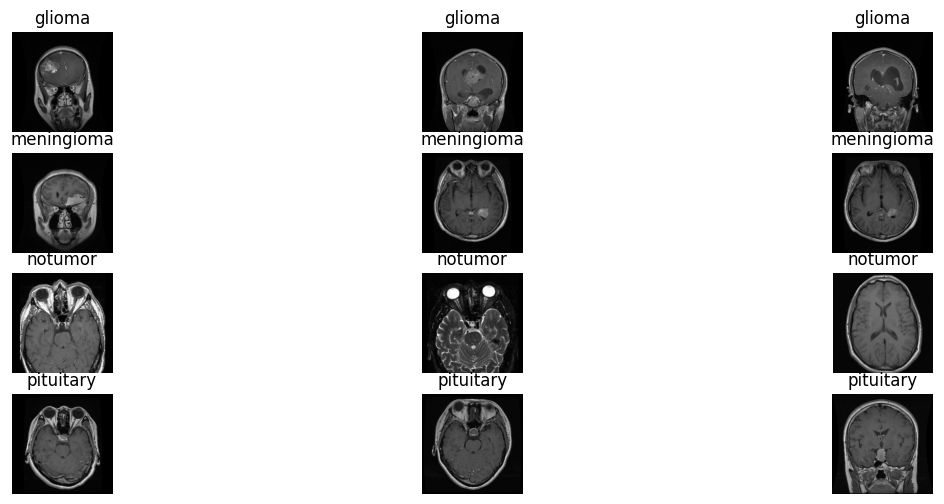

In [5]:

# Function to plot samples
def plot_samples(dataset, num_samples=3):
    fig, axes = plt.subplots(4, num_samples, figsize=(15, 6))
    for i, class_name in enumerate(dataset.classes):
        class_indices = [idx for idx, (_, label) in enumerate(dataset.samples) if label == i]
        for j in range(num_samples):
            img_path, _ = dataset.samples[class_indices[j]]
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].set_title(f'{class_name}')
            axes[i, j].axis('off')
    plt.show()

# Display samples
plot_samples(dataset)

# **Dataset loading for Training and Validation**

In [6]:
# Define basic transformations for loading the images
transform = transforms.Compose([
    transforms.Resize((128,128)),  # Resize images to 128x128 pixels
    transforms.ToTensor()  # Convert images to PyTorch tensors
])

# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=transform)  # Load dataset from data_dir with the specified transform

In [7]:
# Split into training and validation sets (80-20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, lengths=[train_size, val_size])# Randomly split dataset into train and validation sets

# Explore the dataset
print(f'Total images: {len(dataset)}')
print(f'Training images: {len(train_dataset)}')
print(f'Validation images: {len(val_dataset)}')
print(f'Classes: {dataset.classes}')

Total images: 5709
Training images: 4567
Validation images: 1142
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


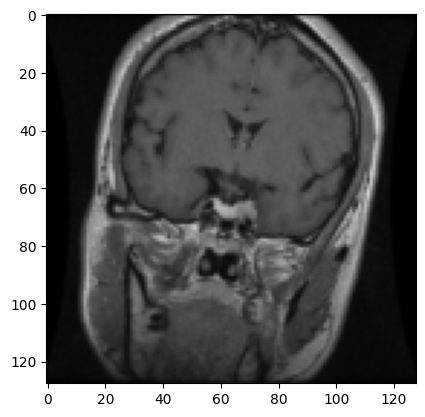

In [8]:
# Visualize a sample image
sample_img, sample_label = train_dataset[5]
plt.imshow(sample_img.permute(1, 2, 0))  # Display the image (make sure to permute for correct format)
#plt.title(f'Label: {"Tumor" if sample_label == 1 else "No Tumor"}')
plt.show()

# **preprocessing and transformation**

In [9]:
# Define transformations for training (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((128,128)),  # Resize images to a consistent size (e.g., 128x128)
    transforms.RandomHorizontalFlip(), # Apply random horizontal flips
    transforms.RandomRotation(10),  # Apply random rotations
    transforms.ToTensor(), # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])  # Normalize images with pre-defined mean and std values
])

In [10]:
# Define transformations for validation (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((128,128)),  # Resize images
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])  # Normalize images
])


In [11]:
 #Apply transformations to the datasets
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform


In [12]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)  # DataLoader for training set with batch_size and shuffle=True
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle=False)   # DataLoader for val set with batch_size and shuffle=False

# **Define Network**

In [13]:
# define hyperparameters
batch_size = 32
epochs = 50
learning_rate = 0.001

In [14]:
class TumorClassifier(nn.Module):
    def __init__(self):
        super(TumorClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3,16, kernel_size=3, padding=1)  # First convolutional layer (input: 3 channels, output: 16)
        self.pool = nn.MaxPool2d(2,2)   # Max pooling layer with 2x2 kernel
        self.conv2 = nn.Conv2d(16,32, kernel_size=3, padding=1)  # Second convolutional layer (input: 16 channels, output: 32)
        self.fc1 = nn.Linear(32*32*32, 128)    # Fully connected layer (input: flattened conv output, output: 128)
        self.fc2 = nn.Linear(128, 4)     # Final fully connected layer for 4 output classes (multi classification) nn.Flatten()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Apply relu + conv1 + pool
        x = self.pool(torch.relu(self.conv2(x)))  # Apply relu + conv2 + pool
        x = x.view(-1, 32*32*32)  # Flatten the tensor #try nn.Flatten()
        x = torch.relu(self.fc1(x))  # Apply relu + fc1
        x = self.fc2(x)  # Output layer (fc2)
        return x

In [15]:
# Instantiate the model and move it to the GPU if available
model = TumorClassifier()  # Create instance of TumorClassifier and move to device
model = model.to("cuda")
print(model)

TumorClassifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


In [16]:

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Set loss function (e.g., CrossEntropyLoss)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Set optimizer (e.g., Adam with model parameters and learning rate)

# **Train the Network**

In [17]:
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to('cuda'), labels.to('cuda')  # Move data to the appropriate device (CPU/GPU)
        
        optimizer.zero_grad()  # Clear previous gradients
        
        outputs = model(images)  # Perform forward pass through the model
        
        loss = criterion(outputs,labels)  # Calculate the loss using criterion
        
        loss.backward()  # Backpropagate the gradients
        optimizer.step()  # Update model weights
        
        running_loss += loss.item()  # Accumulate the loss value
    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

Epoch 1/50, Loss: 0.7905
Epoch 2/50, Loss: 0.3326
Epoch 3/50, Loss: 0.2048
Epoch 4/50, Loss: 0.1251
Epoch 5/50, Loss: 0.0674
Epoch 6/50, Loss: 0.0390
Epoch 7/50, Loss: 0.0161
Epoch 8/50, Loss: 0.0081
Epoch 9/50, Loss: 0.0041
Epoch 10/50, Loss: 0.0019
Epoch 11/50, Loss: 0.0008
Epoch 12/50, Loss: 0.0005
Epoch 13/50, Loss: 0.0004
Epoch 14/50, Loss: 0.0003
Epoch 15/50, Loss: 0.0002
Epoch 16/50, Loss: 0.0002
Epoch 17/50, Loss: 0.0002
Epoch 18/50, Loss: 0.0001
Epoch 19/50, Loss: 0.0001
Epoch 20/50, Loss: 0.0001
Epoch 21/50, Loss: 0.0001
Epoch 22/50, Loss: 0.0001
Epoch 23/50, Loss: 0.0001
Epoch 24/50, Loss: 0.0001
Epoch 25/50, Loss: 0.0001
Epoch 26/50, Loss: 0.0001
Epoch 27/50, Loss: 0.0000
Epoch 28/50, Loss: 0.0000
Epoch 29/50, Loss: 0.0000
Epoch 30/50, Loss: 0.0000
Epoch 31/50, Loss: 0.0000
Epoch 32/50, Loss: 0.0000
Epoch 33/50, Loss: 0.0000
Epoch 34/50, Loss: 0.0000
Epoch 35/50, Loss: 0.0000
Epoch 36/50, Loss: 0.0000
Epoch 37/50, Loss: 0.0000
Epoch 38/50, Loss: 0.0000
Epoch 39/50, Loss: 0.

# **Perform Inference on Validation**

Label Information
Each ground-truth label is a numeric class value representing a brain tumor type:

0 - Glioma
1 - Meningioma
2 - No Tumor
3 - Pituitary Tumor

In [18]:
model.eval()  # Set model to evaluation mode
predictions = []
true_labels = []

with torch.no_grad():  # Disable gradient tracking for inference
    for images, labels in val_loader:
        images = images.to('cuda')  # Move images to the appropriate device
        outputs = model(images)  # Forward pass through the model
        _, predicted = torch.max(outputs, 1)  # Get predicted class with highest score
        predictions.extend(predicted.cpu().numpy())  # Append predictions to the list
        true_labels.extend(labels.numpy())  # Append true labels to the list

In [19]:
# Calculate accuracy
accuracy = np.mean(np.array(predictions) == np.array(true_labels))  # Compute mean of correct predictions
print(f'Test Accuracy: {accuracy:.4f}')


Test Accuracy: 0.9387


In [20]:
from sklearn.metrics import f1_score
# Calculate F1 score
f1 = f1_score(true_labels, predictions, average='weighted')
print(f'Test F1 Score: {f1:.4f}')

Test F1 Score: 0.9383


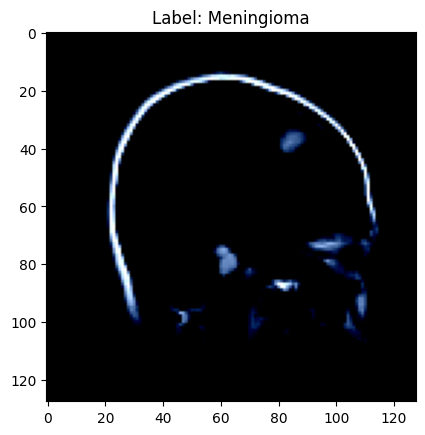

In [21]:
# Visualize a sample prediction
index = 1114 # Choose an index to visualize
sample_img, sample_label = val_dataset[index]
plt.imshow(sample_img.permute(1,2,0))  # Display the image (make sure to permute for correct format)
pred_label = predictions[index]
# 1. Define the mapping from the numeric label to the category name
#    (Ideally, define this once earlier in your script)
label_map = {
    0: "Glioma",
    1: "Meningioma",
    2: "No Tumor",
    3: "Pituitary Tumor"
}

# 2. Assume 'sample_label' contains the numeric ground-truth label (0, 1, 2, or 3)
#    for the image being displayed.

#    We need to handle if sample_label is a PyTorch tensor or a plain number.
if torch.is_tensor(sample_label):
    label_number = sample_label.item() # Extract Python number from tensor
else:
    label_number = sample_label # Assume it's already a Python number

# 3. Look up the corresponding name in the map
#    Using .get() provides a default "Unknown Label" if the number isn't in the map
label_name = label_map.get(int(label_number), "Unknown Label") # Use int() just to be safe

# 4. Set the title using the retrieved label name
#    This replaces your original plt.title line
plt.title(f'Label: {label_name}')
#plt.title(f'Predicted: {"Glioma " if pred_label == 0 else "No Tumor"}, True: {"Tumor" if sample_label == 1 else "No Tumor"}')
plt.show()

# **Load Testdataset**

In [22]:
# Define the dataset path
data_dir = '/kaggle/input/tumor-datasets002/Testing'

# Define basic transformations for loading the images
test_transform = transforms.Compose([
    transforms.Resize((128,128)),  # Resize images to 128x128 pixels
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])
])

# Load the dataset without transformations
test_dataset = datasets.ImageFolder(root=data_dir, transform = test_transform)
# Count images per class
class_counts = Counter([label for _, label in test_dataset.samples])
print(f'Class distribution: {class_counts}')

# Print sizes of the first 5 images
print("Original sizes of the first 5 images:")
for i in range(5):
    img_path, label = test_dataset.samples[i]
    with Image.open(img_path) as img:
        print(f'Image {i}: {img.size} (Class: {dataset.classes[label]})')
print("Class names in order:", test_dataset.classes)

Class distribution: Counter({2: 405, 1: 306, 0: 300, 3: 300})
Original sizes of the first 5 images:
Image 0: (512, 512) (Class: glioma)
Image 1: (512, 512) (Class: glioma)
Image 2: (512, 512) (Class: glioma)
Image 3: (512, 512) (Class: glioma)
Image 4: (512, 512) (Class: glioma)
Class names in order: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [23]:
#test_dataset.dataset.transform = test_transform
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle=False)   # DataLoader for val set with batch_size and shuffle=False

# **perform inference on test_dataset**

In [24]:
# Prediction on test dataset

predictions = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probabilities = torch.softmax(outputs, dim=1) # Get probabilities
        predicted_classes = torch.argmax(probabilities, dim=1) # Get the class with highest probability
        predictions.extend(predicted_classes.cpu().numpy())

test_preds = np.array(predictions)

print(len(predictions))

1311


In [25]:
# Create submission DataFrame
# Extract just the base file names (without the directory)
image_paths = [item[0] for item in test_dataset.samples]
image_names = [path.split('/')[-1] for path in image_paths]

# Create the new 'image_name' list in the desired format
#image_names = [f"img_{i+1:03d}.jpg" for i in range(len(image_names))]
# Create the new 'image_name' list in the desired format
new_image_names = []
for i, name in enumerate(image_names):
    if "Te-glTr" in name:
        new_name = f"Te-gl_{i+1:04d}.jpg"
    elif "Te-meTr" in name:
        new_name = f"Te-me_{i+1:04d}.jpg"
    elif "Te-noTr" in name:
        new_name = f"Te-no_{i+1:04d}.jpg"
    elif "Te-gl" in name:
        new_name = f"Te-gl_{i+1:04d}.jpg"
    elif "Te-me" in name:
        new_name = f"Te-me_{i+1:04d}.jpg"
    elif "Te-no" in name:
        new_name = f"Te-no_{i+1:04d}.jpg"
    else:
        new_name = f"img_{i+1:04d}.jpg"  # Default if no prefix matches
    new_image_names.append(new_name)
# Create submission
submission_df = pd.DataFrame({
    "image_name": image_names,
    "label":   test_preds
})
submission_df.to_csv("/kaggle/working/Tumor_submission003.csv", index=False)
